### **Лабораторная работа**

# Погнали
###  **Задача: предсказать оценку релевантности для запросов тестового датасета**


Мы будем работать на данных с конкурса [Интернет-математика 2009](https://academy.yandex.ru/events/data_analysis/grant2009/). По ссылке можно прочитать описание данных.      

Данные
> Данные разбиты на две выборки – обучающая выборка imat2009_learning.txt с известными оценками близости запроса и документа и тестовая выборка с неизвестными близостями imat2009_test.txt  

Обучающая выборка
> Данные для обучения содержат **97 290 строк**, которые соответствуют **9 124 запросам**  
Каждая строка соответствует паре «запрос-документ»    

Признаки
>Каждой паре «запрос-документ» соответствуют значения **245 признаков**. Формат хранения feat_num:value. Если значение признака равно 0, то он опускается.     
В комментариях в конце каждой строки указан **идентификатор запроса**.   
Файл с обучающей выборкой содержит **оценку релевантности**, значения из диапазона **[0, 4]** (4 – «высокая релевантность», 0 – «нерелевантно»).   


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('gdrive/My Drive/Colab Notebooks')

### DATA

In [1]:
# LOAD TRAIN DATA
file_learning = 'imat2009_learning.txt'

with open(file_learning) as f:
    train_data = f.readlines()
    
    
# LOAD TEST DATA
file_test = 'imat2009_test.txt'

with open(file_test) as f:
    test_data = f.readlines()


In [2]:
len(train_data), len(test_data)

(97290, 115643)

Структура данных следующая - первый элемент в строке - это оценка близости запроса и документа, дальше идут признаки документа, а последний элемент строки - это id запроса:

> RELEVANCE      feature:value feature:value ... feature:value     # QUERY_ID

In [3]:
train_data[0]

'1 1:0.000023 7:0.704953 8:0.550315 9:0.032294 11:0.712631 14:0.015686 15:0.137255 16:0.302576 17:1.000000 18:0.996078 22:1.000000 23:1.000000 24:1.000000 27:0.700000 28:0.587629 29:0.999881 30:0.032294 34:0.000023 36:0.431373 37:0.002247 38:0.054902 41:1.000000 46:0.002247 50:0.032294 51:0.325613 52:0.056641 53:0.820677 54:0.388235 55:0.450980 56:0.312547 57:0.004672 59:1.000000 61:0.000023 65:1.000000 68:0.712195 69:0.001400 70:1.000000 71:0.001013 73:0.709459 74:0.560784 76:0.142857 77:0.360800 78:1.000000 79:1.000000 80:1.000000 82:0.000023 83:1.000000 85:0.996078 86:0.070588 87:1.000000 88:0.999797 92:1.000000 93:0.714286 95:0.039216 97:0.000023 98:0.356490 99:0.165041 102:1.000000 103:1.000000 104:1.000000 105:0.486275 108:0.152941 120:0.996078 121:0.676507 122:0.032294 126:0.712980 128:0.121569 129:0.609261 132:1.000000 134:0.109804 135:0.030535 140:0.002247 142:0.698039 144:0.248111 145:0.356490 146:1.000000 147:0.498039 148:0.125490 150:0.704953 151:1.000000 152:0.098039 154:0

В test_data все оценки релевантности скрыты, поскольку этот набор данных использовался для проверки качества работы алгоритма в конкурсе. Нам эти данные не нужны, дальше работаем только с **train_data**.

Для проверки качества будущей модели надо разбить обучающую выборку на обучение и валидацию в соотношении 70 / 30

Внимание: разбивать необходимо **множество запросов QUERY_ID**, а не строчки датасета, чтобы в выборке находилась вся информация по запросу

Для этого вам надо:
1. собрать все запросы для каждого QUERY_ID

```
{
query_id : [
    RELEVANCE feature:value ... feature:value,
    ...
],
...
}
```

При этом я бы сразу собирала не сами данные, а номер строки в матрице данных
```
{
query_id : [
    line_num, line_num, ... line_num
],
...
}
```
2. собрать матрицу данных, размер вектора равен числу признаков = 245
```
data = np.zeros((len(train_data), feats_num), dtype=np.float32) 
```

3. собрать вектор с оценками релевантности, его размер равен размеру train_data

In [4]:
import numpy as np
from collections import defaultdict

labels = [] 
queries_lines_info = defaultdict(list) #словарь: по ключу id query, значения - строки с подходящими документами

train_data = train_data[:100] #100
data = np.zeros((len(train_data), 245), dtype=np.float32) 

#YOUR CODE HERE
for i, line in enumerate(train_data):
    line_data = line.split(' ')
    
    label = float(line_data[0])
    query_id = int(line_data[-1])
    
    labels.append(label)
    queries_lines_info[query_id].append(i)
    
    for feat_data in line_data[1:-2]:
        feat_id, feat_value = feat_data.split(':')
        feat_id = int(feat_id) - 1
        
        data[i, feat_id] = feat_value


In [ ]:
# check
assert data.shape == (len(train_data), 245)
assert len(queries.keys()) == 9124
assert len(labels) == len(train_data)

Разделим запросы из *queries_lines_info.keys()* на обучающую *train_queries_ids* и валидационную выборки *test_queries_ids* (70/30)

In [5]:
from sklearn.model_selection import train_test_split

#YOUR CODE HERE
queries_ids = list(queries_lines_info.keys())
train_queries_ids, test_queries_ids = train_test_split(queries_ids, test_size = 0.33, random_state = 42)

In [6]:
train_queries_ids

[11546, 21991, 11800, 3483, 11542, 11544, 19719, 11547]

In [0]:
# check
assert len(train_queries_ids) / (len(train_queries_ids) + len(test_queries_ids)) == 0.6999123191582639

 > Теперь у нас есть:  
 1) айдишники запросов для обучения и валидации **queries_id_train, queries_id_test**   
 2) матрица данных **data**   
 3) словарь **queries** с информацией о том, какие строчки в этой матрице соответствуют какому айдишнику  
 
 С помощью этих данных разделите матрицу data на матрицы **X_train, y_train, X_test, y_test**

In [0]:
# изи пизи способ получить несколько строк матрицы по их id данные матрицы
data_example = np.array(
    [
        [0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]
    ]
)

data_example[[0, 3]]

array([[0, 0, 0],
       [3, 3, 3]])

In [8]:
print(train_queries_ids)

[11546, 21991, 11800, 3483, 11542, 11544, 19719, 11547]


In [7]:
# разбиваем номера строк исходной матрицы на train и test
train_queries_lines_info = []
test_queries_lines_info = []

labels = np.array(labels)

for query_id in train_queries_ids:
    train_queries_lines_info += queries_lines_info[query_id]

for query_id in test_queries_ids:
    test_queries_lines_info += queries_lines_info[query_id]

X_train, y_train = data[train_queries_lines_info], labels[train_queries_lines_info]
X_test, y_test = data[test_queries_lines_info], labels[test_queries_lines_info]

In [9]:
train_queries_lines_info = np.array(train_queries_lines_info)
test_queries_lines_info = np.array(test_queries_lines_info)

In [0]:
assert X_train.shape == (68418, 245) 
assert len(y_train) == 68418

Поздравляю, если вы все сделали до этого моменты, вы восхитительны! 

Данные готовы, можно заряжать модели                                                           
Для оценивания качества моделей используйте метрику nDCG, реализованную ниже

In [11]:
import metrics

#test_lines = np.array(test_lines)


def get_nDCG_score(queries, queries_lines_info, test_queries_lines_info, labels_true, labels_predicted):
    nDCG_scores = [] # nDCG по каждому запросу
    
    for query in queries:
        
        query_lines = queries_lines_info[query]
        query_lines_in_testdata = [np.where(test_queries_lines_info==line)[0][0] for line in query_lines]
        
        query_labels_true = labels[query_lines]
        query_labels_pred = labels_predicted[query_lines_in_testdata]
        
        nDCG = metrics.ndcg_score(query_labels_true, query_labels_pred, k=10)
        nDCG_scores.append(nDCG)
        
    nDCG_Queries = np.sum(nDCG_scores) / len(queries) # усредняем по всем запросам
    return nDCG_Queries


### FIT PREDICT

Воспользовавшись известными вам техниками построения линейной регрессии, обучите модель, предсказывающую оценку асессора

``` from sklearn.linear_model import LinearRegression``` 

In [12]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_reg_y_pred = lin_reg.predict(X_test)

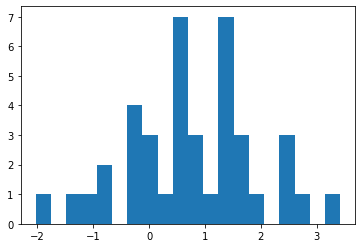

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

h = plt.hist(lin_reg_y_pred, bins=20)

Посчитаем качество модели по метрике **nDCG**

In [17]:
score_lin_reg = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = lin_reg_y_pred
)

score_lin_reg

0.8133502213419102

Давайте теперь решим эту задачу не как регрессию, а как классификацию

In [24]:
#Сделаем препроцессинг из-за появляющейся valueerror
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
new_y_train = label_encoder.fit_transform(y_train)

In [25]:
from sklearn.svm import LinearSVC

lin_svc = LinearSVC()
lin_svc.fit(X_train, new_y_train)

lin_svc_y_pred = lin_svc.predict(X_test)

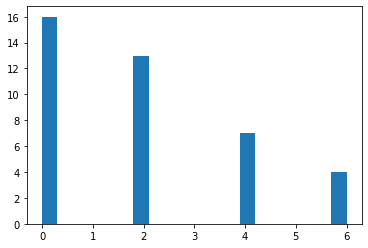

In [26]:
h2 = plt.hist(lin_svc_y_pred, bins=20)

In [27]:
score_lin_reg = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = lin_svc_y_pred
)

score_lin_reg

0.6906636693498291

#### Ранжируем с RandomForestRegressor

In [29]:
from sklearn.ensemble import RandomForestRegressor

rforest = RandomForestRegressor()
rforest.fit(X_train, y_train)

rforest_y_pred = rforest.predict(X_test)

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


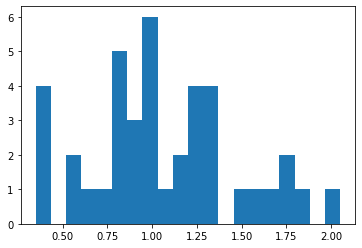

In [30]:
h3 = plt.hist(rforest_y_pred, bins=20)

In [31]:
score_rf = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = rforest_y_pred
)

score_rf

0.8216730797857877

#### Ранжируем с XGBoost

In [33]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [35]:
import xgboost

xgb = xgboost.XGBClassifier()
xgb.fit(X_train, y_train)

xgb_y_pred = xgb.predict(X_test)

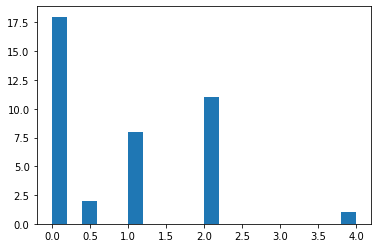

In [36]:
h4 = plt.hist(xgb_y_pred, bins=20)

In [37]:
score_xb = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = xgb_y_pred
)

score_xb

0.71618230634635

#### Ранжируем с LightGBM

In [39]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [41]:
import lightgbm

lgbm = lightgbm.LGBMRegressor()
lgbm.fit(X_train, y_train)

lgbm_y_pred = lgbm.predict(X_test)

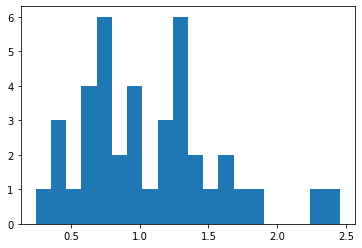

In [42]:
h5 = plt.hist(lgbm_y_pred, bins=20)

In [43]:
score_gbm = get_nDCG_score(
    queries = test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = lgbm_y_pred
)

score_gbm

0.6631232248065503